In [1]:
import tensorflow as tf

In [2]:
import tensorflow as tf

# Load the saved model
model = tf.keras.models.load_model('./barin_tumor.h5')


In [3]:
IMAGE_SIZE = 512
BATCH_SIZE=5
CHANNELS = 3
EPOCHS = 5 

In [4]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "../Brain Tumor data/Training",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)


Found 5713 files belonging to 4 classes.


In [6]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_ds)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

115/115 [==============================] - 35s 38ms/step - loss: 0.1459 - accuracy: 0.9426
Test Loss: 0.14590445160865784
Test Accuracy: 0.9426087141036987


In [7]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 512, 512, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 510, 510, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 255, 255, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 253, 253, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 126, 126, 64)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 124, 124, 64)     

In [8]:
import numpy as np

# Initialize lists to store true and predicted labels
y_true = []
y_pred = []

for images, labels in test_ds:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)


In [39]:
from sklearn.metrics import classification_report

# Assuming y_true and y_pred are already defined
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Generate the classification report
report = classification_report(y_true, y_pred, target_names=class_names)

# Print the classification report
print(report)


              precision    recall  f1-score   support

      glioma       0.95      0.87      0.91       131
  meningioma       0.79      0.90      0.84       125
     notumor       0.98      0.96      0.97       167
   pituitary       0.95      0.93      0.94       152

    accuracy                           0.92       575
   macro avg       0.92      0.91      0.91       575
weighted avg       0.92      0.92      0.92       575



# Confusion Matrix

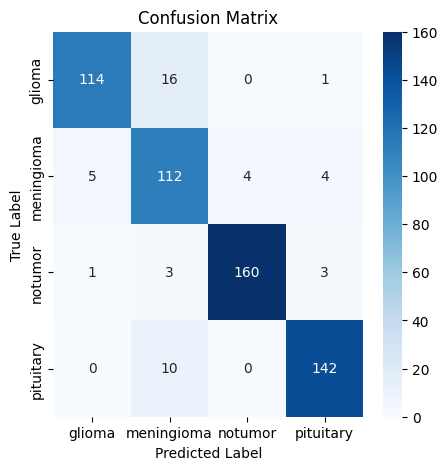

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming y_true and y_pred are already defined
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


# Classification Report

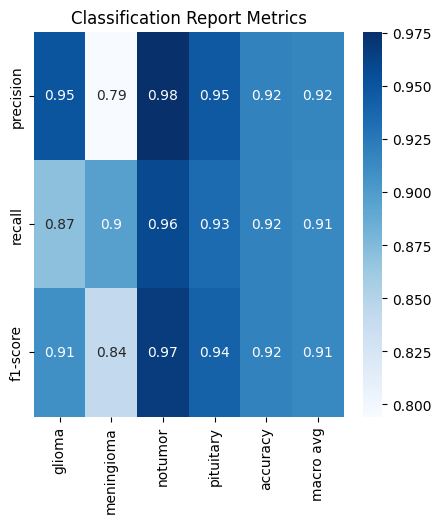

In [41]:
import pandas as pd
from sklearn.metrics import classification_report

# Generate the classification report as a dictionary
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)

# Convert the report into a DataFrame
report_df = pd.DataFrame(report).transpose()

# Drop columns if they exist
columns_to_drop = ["support", "accuracy"]
report_df = report_df.drop(columns=[col for col in columns_to_drop if col in report_df.columns])

# Create a heatmap for the classification report
plt.figure(figsize=(5,5))
sns.heatmap(report_df.iloc[:-1, :].T, annot=True, cmap="Blues")
plt.title('Classification Report Metrics')
plt.show()


In [42]:
from matplotlib.backends.backend_pdf import PdfPages

report = classification_report(y_true, y_pred, target_names=class_names)

with PdfPages('model_evaluation_report.pdf') as pdf:
    
    # Text report as table
    plt.figure(figsize=(12, 10))
    plt.suptitle('Classification Report', fontsize=16, fontweight='bold', y=0.95)
    
    # Create table for the classification report
    table_data = report_df.reset_index()
    table_data.columns = ['Precision', 'Recall', 'F1-Score', 'Support']
    
    ax = plt.gca()
    ax.axis('off')  # Hide the axes
    
    # Create a table and add it to the figure
    table = plt.table(cellText=table_data.values,
                      colLabels=table_data.columns,
                      cellLoc='center',
                      loc='center',
                      bbox=[0, 0, 1, 1],
                      colColours=['lightgrey']*len(table_data.columns))
    
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.2, 1.2)  # Adjust the scale as needed
    
    pdf.savefig()
    plt.close()
    
    # Confusion Matrix
    plt.figure(figsize=(10, 7))
    plt.suptitle('Confusion Matrix', fontsize=16, fontweight='bold', y=0.95)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    pdf.savefig()  # saves the current figure into a pdf page
    plt.close()
    
    # Classification Report Metrics
    plt.figure(figsize=(12, 8))
    plt.suptitle('Classification Report Metrics', fontsize=16, fontweight='bold', y=0.95)
    sns.heatmap(report_df.iloc[:-1, :].T, annot=True, cmap="Blues")
    plt.title('Classification Report Metrics')
    pdf.savefig()
    plt.close()

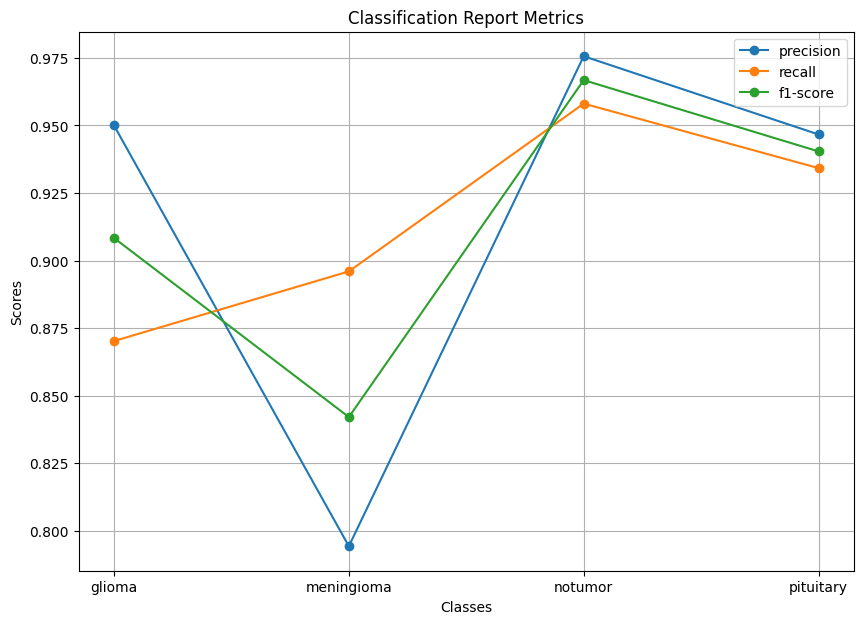

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

# Assuming y_true and y_pred are already defined
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Generate the classification report
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)

# Extract metrics
metrics = ['precision', 'recall', 'f1-score']
report_dict = {metric: [report[label][metric] for label in class_names] for metric in metrics}
report_dict['class'] = class_names

# Plot line plots for each metric
plt.figure(figsize=(10, 7))
for metric in metrics:
    plt.plot(report_dict['class'], report_dict[metric], marker='o', label=metric)

plt.xlabel('Classes')
plt.ylabel('Scores')
plt.title('Classification Report Metrics')
plt.legend()
plt.grid(True)
plt.show()


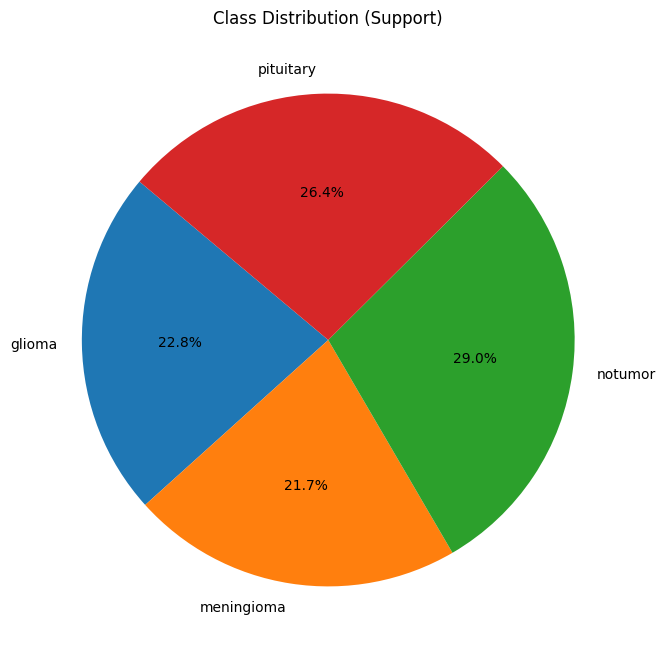

In [78]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Assuming y_true and y_pred are already defined
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Generate the classification report
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)

# Extract support for each class
supports = [report[label]['support'] for label in class_names]

# Plot pie chart
plt.figure(figsize=(8, 8))
plt.pie(supports, labels=class_names, autopct='%1.1f%%', startangle=140)
plt.title('Class Distribution (Support)')
plt.show()


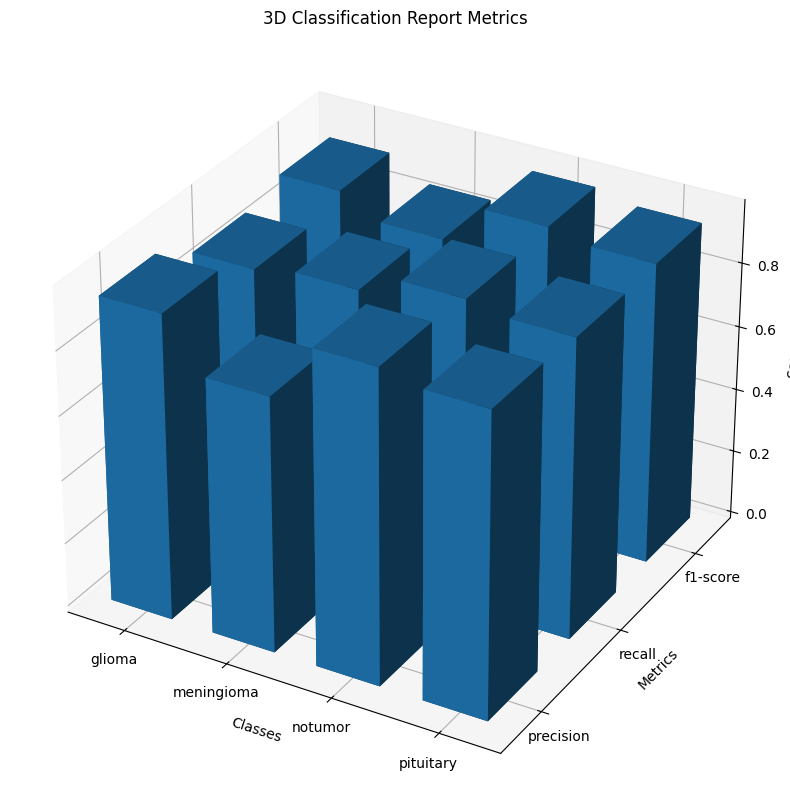

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import classification_report

# Assuming y_true and y_pred are already defined
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Generate the classification report
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)

# Extract metrics
metrics = ['precision', 'recall', 'f1-score']
report_dict = {metric: [report[label][metric] for label in class_names] for metric in metrics}

# Create a 3D plot
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Define the positions of bars
x = np.arange(len(class_names))
y = np.arange(len(metrics))

x_pos, y_pos = np.meshgrid(x, y)
x_pos = x_pos.flatten()
y_pos = y_pos.flatten()
z_pos = np.zeros_like(x_pos)

# Define the width, depth, and height of the bars
dx = dy = 0.6
dz = np.array([report_dict[metric][i] for metric in metrics for i in x]).flatten()

# Plot bars
ax.bar3d(x_pos, y_pos, z_pos, dx, dy, dz, shade=True)

# Labels and title
ax.set_xlabel('Classes')
ax.set_ylabel('Metrics')
ax.set_zlabel('Scores')
ax.set_xticks(x + dx / 2)
ax.set_xticklabels(class_names)
ax.set_yticks(y + dy / 2)
ax.set_yticklabels(metrics)
ax.set_title('3D Classification Report Metrics')

plt.show()


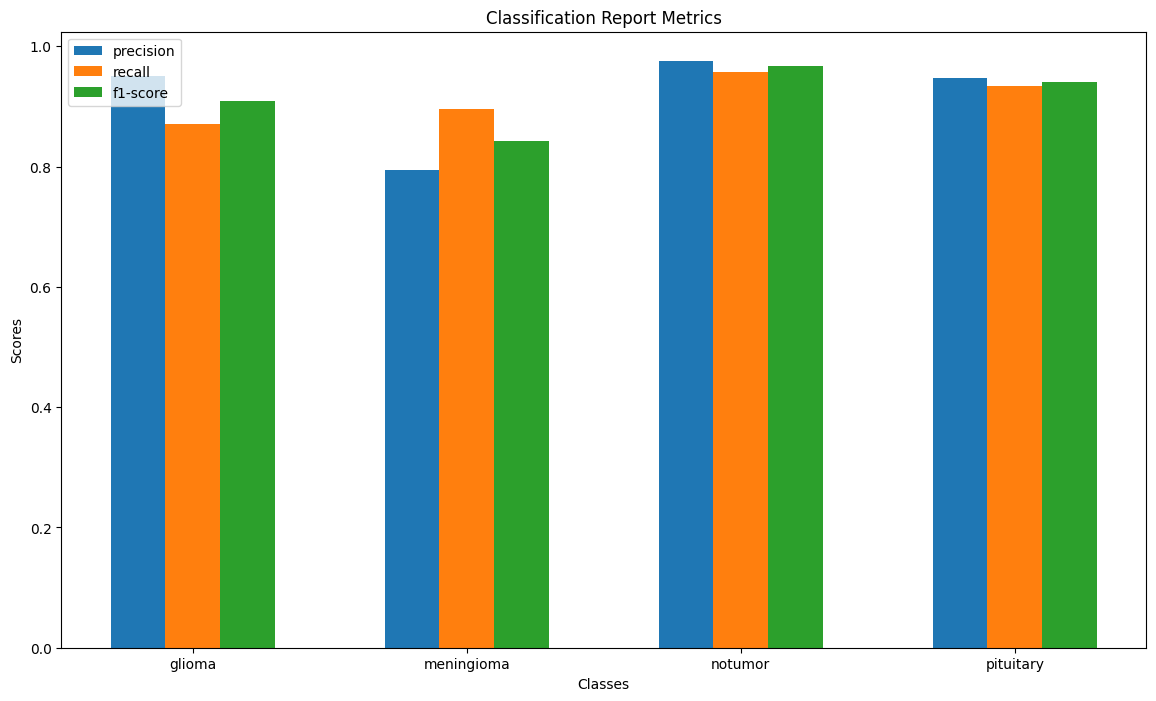

In [46]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)

# Extract metrics
metrics = ['precision', 'recall', 'f1-score']
report_dict = {metric: [report[label][metric] for label in class_names] for metric in metrics}

# Plot bar graphs for each metric
x = np.arange(len(class_names))
width = 0.2

plt.figure(figsize=(14, 8))
for i, metric in enumerate(metrics):
    plt.bar(x + i * width, report_dict[metric], width=width, label=metric)

plt.xlabel('Classes')
plt.ylabel('Scores')
plt.title('Classification Report Metrics')
plt.xticks(x + width, class_names)
plt.legend()
plt.show()


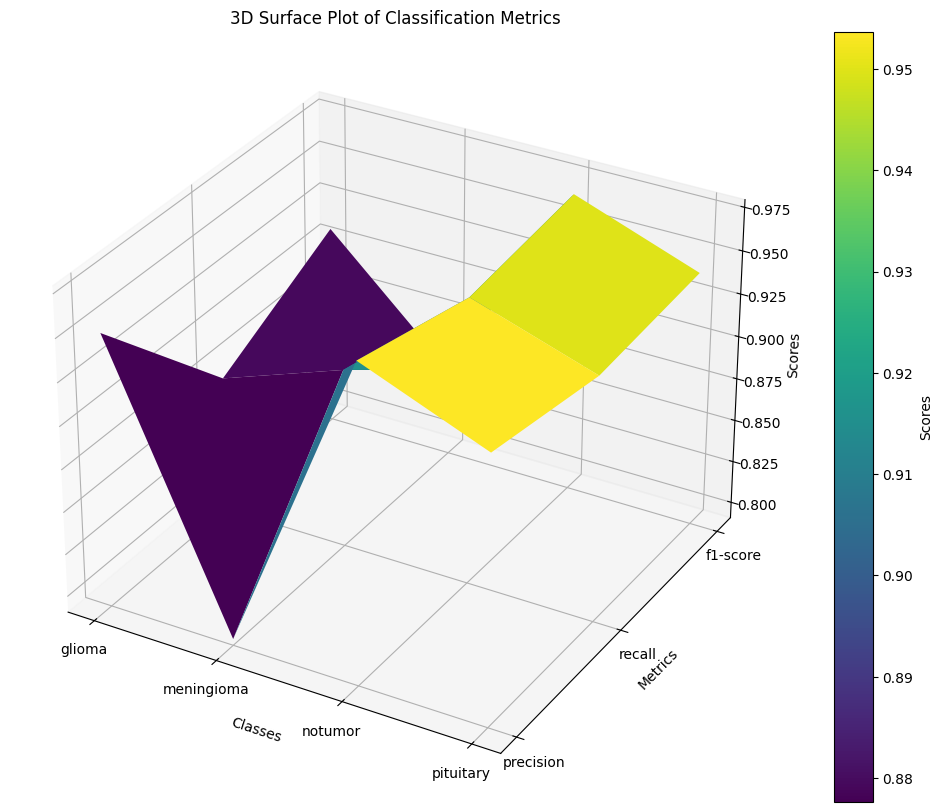

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)

# Extract metrics
metrics = ['precision', 'recall', 'f1-score']
report_dict = {metric: [report[label][metric] for label in class_names] for metric in metrics}

# Create a 3D surface plot
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Prepare data for surface plot
X, Y = np.meshgrid(np.arange(len(class_names)), np.arange(len(metrics)))
Z = np.array([report_dict[metric] for metric in metrics])

# Plot surface
surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')

# Labels and title
ax.set_xlabel('Classes')
ax.set_ylabel('Metrics')
ax.set_zlabel('Scores')
ax.set_xticks(np.arange(len(class_names)))
ax.set_xticklabels(class_names)
ax.set_yticks(np.arange(len(metrics)))
ax.set_yticklabels(metrics)
ax.set_title('3D Surface Plot of Classification Metrics')

# Create a colorbar
cbar = plt.colorbar(surf, ax=ax)
cbar.set_label('Scores')

plt.show()


In [89]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages

class_names = report_df.index.tolist()
metrics = ['precision', 'recall', 'f1-score']

# Prepare data for plots
report_dict = {metric: report_df[metric].tolist() for metric in metrics}
report_dict['class'] = class_names

with PdfPages('model_evaluation_report1.pdf') as pdf:
    # Text Report as Table
    plt.figure(figsize=(12, 10))
    plt.suptitle('Classification Report', fontsize=16, fontweight='bold', y=0.95)
    
    # Create table for the classification report
    table_data = report_df.reset_index()
    table_data.columns = ['Precision', 'Recall', 'F1-Score', 'Support']
    
    ax = plt.gca()
    ax.axis('off')  # Hide the axes
    
    # Create a table and add it to the figure
    table = plt.table(cellText=table_data.values,
                      colLabels=table_data.columns,
                      cellLoc='center',
                      loc='center',
                      bbox=[0, 0, 1, 1],
                      colColours=['lightgrey']*len(table_data.columns))
    
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.2, 1.2) 
    pdf.savefig()
    plt.close()

    # Confusion Matrix
    plt.figure(figsize=(10, 7))
    class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']
    cm1 = confusion_matrix(y_true, y_pred)
    plt.suptitle('Confusion Matrix', fontsize=16, fontweight='bold', y=0.93)
    sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    pdf.savefig()  # saves the current figure into a pdf page
    plt.close()

    # Classification Report Metrics Heatmap
    plt.figure(figsize=(12, 8))
    plt.suptitle('Classification Report Metrics', fontsize=16, fontweight='bold',y=0.93)
    sns.heatmap(report_df.T, annot=True, cmap="Blues")
    pdf.savefig()
    plt.close()
    
    
    # Line Plot for Classification Metrics
    plt.figure(figsize=(10, 7))
    for metric in metrics:
        plt.plot(report_dict['class'], report_dict[metric], marker='o', label=metric)
    plt.xlabel('Classes')
    plt.ylabel('Scores')
    plt.legend()
    plt.title('Distribution report')
    plt.grid(True)
    pdf.savefig()
    plt.close()
    
    # Pie Chart for Class Distribution
    class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    supports = [report[label]['support'] for label in class_names]
    plt.figure(figsize=(8, 8))
    plt.pie(supports, labels=class_names, autopct='%1.1f%%', startangle=140)
    plt.title('Class Distribution (Support)')
    pdf.savefig()
    plt.close()
    
    # 3D Bar Plot for Metrics
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')
    x = np.arange(len(report_dict['class']))
    y = np.arange(len(metrics))
    x_pos, y_pos = np.meshgrid(x, y)
    x_pos = x_pos.flatten()
    y_pos = y_pos.flatten()
    z_pos = np.zeros_like(x_pos)
    dx = dy = 0.6
    dz = np.array([report_dict[metric][i] for metric in metrics for i in x]).flatten()
    ax.bar3d(x_pos, y_pos, z_pos, dx, dy, dz, shade=True)
    ax.set_xlabel('Classes')
    ax.set_ylabel('Metrics')
    ax.set_zlabel('Scores')
    ax.set_xticks(x + dx / 2)
    ax.set_xticklabels(report_dict['class'])
    ax.set_yticks(y + dy / 2)
    ax.set_yticklabels(metrics)
    ax.set_title('3D Classification Report Metrics')
    pdf.savefig()
    plt.close()
    
    # 3D Surface Plot for Metrics
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')
    X, Y = np.meshgrid(np.arange(len(report_dict['class'])), np.arange(len(metrics)))
    Z = np.array([report_dict[metric] for metric in metrics])
    surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')
    ax.set_xlabel('Classes')
    ax.set_ylabel('Metrics')
    ax.set_zlabel('Scores')
    ax.set_xticks(np.arange(len(report_dict['class'])))
    ax.set_xticklabels(report_dict['class'])
    ax.set_yticks(np.arange(len(metrics)))
    ax.set_yticklabels(metrics)
    ax.set_title('3D Surface Plot of Classification Metrics')
    cbar = plt.colorbar(surf, ax=ax)
    cbar.set_label('Scores')
    pdf.savefig()
    plt.close()
    
    # Bar Graphs for Each Metric
    x = np.arange(len(report_dict['class']))
    width = 0.2
    plt.figure(figsize=(14, 8))
    for i, metric in enumerate(metrics):
        plt.bar(x + i * width, report_dict[metric], width=width, label=metric)
    plt.xlabel('Classes')
    plt.ylabel('Scores')
    plt.title('Classification Report Metrics')
    plt.xticks(x + width, report_dict['class'])
    plt.legend()
    pdf.savefig()
    plt.close()

